In [1]:
%pylab inline
import camels_library as cl
import readgadget
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


## Loading CAMELS data

In [2]:
scales = []
poss = []
vels = []

snapshot='/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_000.hdf5'

header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3 #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]     #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 32).reshape([256,256,256,3])[2::8,2::8,2::8,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*32).reshape([256,256,256,3])[2::8,2::8,2::8,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [01:48<00:00,  3.19s/it]


## Runing PM simulation

In [3]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

mesh_shape= [32, 32, 32]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.671 , sigma8=0.8)

In [4]:
# Run the simulation with Particle-Mesh scheme
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

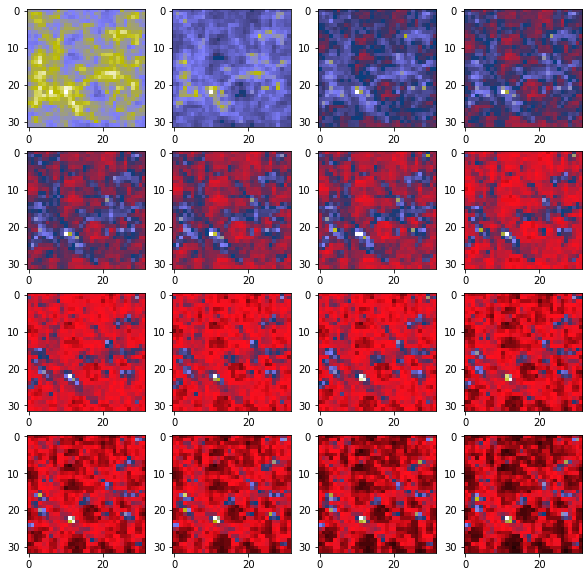

In [5]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

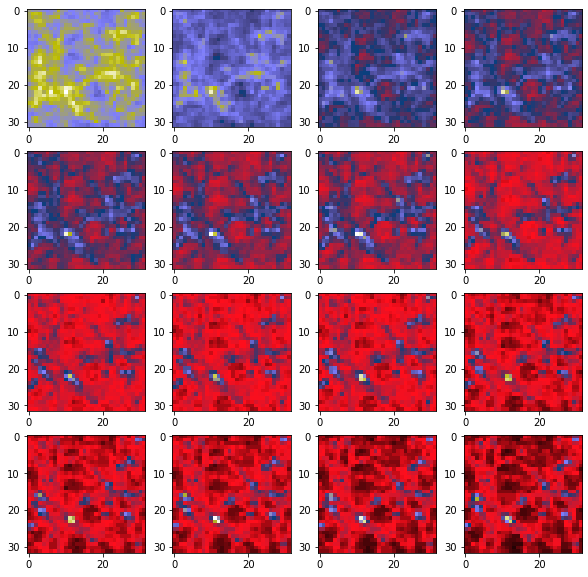

In [6]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [7]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

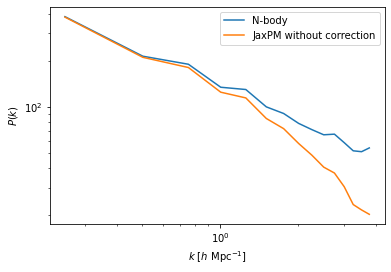

In [8]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

## Implementation of a plain Hamiltonian Graph Neural Network

In [9]:
# We start by computing a neighboorhood to compute PP interactions 
# Could we see if we could get a graph on this
from sklearn.neighbors import radius_neighbors_graph

A = radius_neighbors_graph(poss[-1], 1.5, mode='distance').tocoo()

In [10]:
import jraph
from frozendict import frozendict

# Initialize graph structure
static_graph = jraph.GraphsTuple(
    n_node=np.asarray([A.shape[0]]),
    n_edge=np.asarray([len(A.data)]),
    nodes={
        'position': poss[0],
        'momentum': vels[0],
    },
    senders=A.row,
    receivers=A.col,
    edges={'grav_potential':jnp.zeros(len(A.data))},
    globals={}
)

# Tell tree_util how to navigate frozendicts.
jax.tree_util.register_pytree_node(
    frozendict,
    flatten_func=lambda s: (tuple(s.values()), tuple(s.keys())),
    unflatten_func=lambda k, xs: frozendict(zip(k, xs)))

In [11]:
A

<32768x32768 sparse matrix of type '<class 'numpy.float64'>'
	with 8060958 stored elements in COOrdinate format>

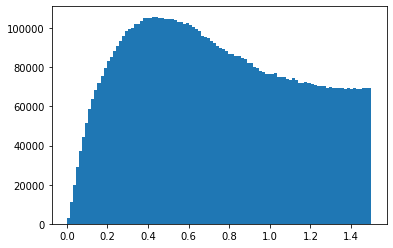

In [12]:
hist(A.data,100);

**Note**: we are not using a fully connected graph here, so we won't get the long range interactions, only the small scales

In [27]:
def update_edge_fn(edges, senders, receivers, globals_):
    del globals_
    # Models particle-particle interactions contribution to grav potential
    distance = jnp.linalg.norm(senders["position"] - receivers["position"], axis=1)
    grav_potential_per_edge = - 1. /(distance + 0.1) # The 0.1 is to soften the forces on small scales
    return frozendict({"grav_potential": grav_potential_per_edge})

def update_node_fn(nodes, sent_edges, received_edges, globals_):
    del sent_edges, received_edges, globals_
    
    # Computes momentum
    momentum_norm = jnp.linalg.norm(nodes["momentum"],axis=1)
    kinetic_energy = 0.5 * momentum_norm ** 2 
    return frozendict({"kinetic_energy": kinetic_energy})

def update_global_fn(nodes, edges, globals_):
    del globals_
    # At this point we will receive node and edge features aggregated (summed)
    # for all nodes and edges in each graph.
    hamiltonian_per_graph =  nodes["kinetic_energy"] + edges["grav_potential"]
    return frozendict({"hamiltonian": hamiltonian_per_graph})

# Create the Hamiltonian Graph
hamiltonian_gnn = jraph.GraphNetwork(
                      update_edge_fn=update_edge_fn,
                      update_node_fn=update_node_fn,
                      update_global_fn=update_global_fn)

# Function that computes the hamiltonian for input position and momentum
def hamiltonian_from_state_fn(position, momentum):
    # Update variables in graph
    graph = static_graph._replace(nodes={
        'position': position,
        'momentum': momentum})
    output_graph = hamiltonian_gnn(graph)
    return output_graph.globals["hamiltonian"].sum()

# Computes the derivatives of the Hamiltonian
hamiltonian_gradients_fn = jax.grad(hamiltonian_from_state_fn, argnums=[0, 1])

In [28]:
@jax.jit
def gnn_nbody_ode(state, a, cosmo):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    # Take the derivatives against position and momentum of the hamiltonian of the system
    dh_dposition, dh_dmomentum = hamiltonian_gradients_fn(pos, vel)
    
    # Hamilton equations
    dpos_da = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * dh_dmomentum
    dvel_da = - 1.5 * cosmo.Omega_m / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * dh_dposition

    return dpos_da, dvel_da

In [29]:
res = odeint(gnn_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-4, atol=1e-4)

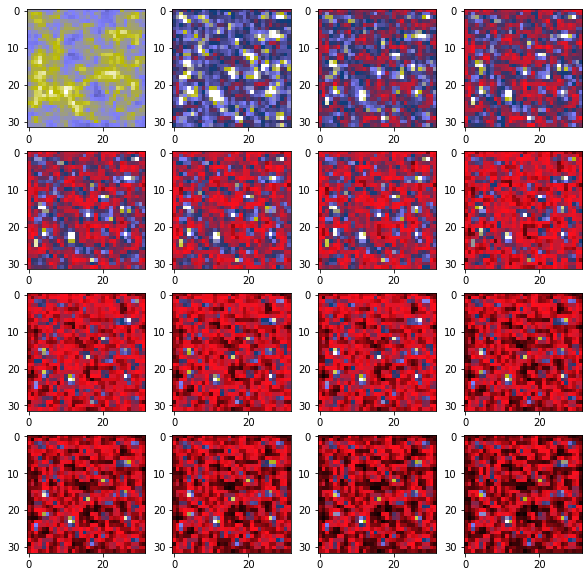

In [30]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [31]:
k, pk_c = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

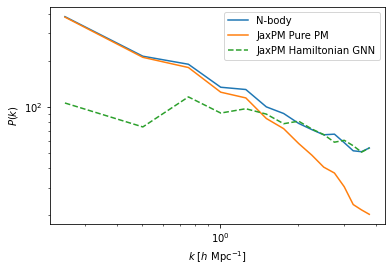

In [32]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM Pure PM')
loglog(k, pk_c, '--', label='JaxPM Hamiltonian GNN')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

## Try to combine large scale PM forces with PP interactions

In [13]:
from jaxpm.nn import NeuralSplineFourierFilter

In [90]:
# Instantiate the neural network
model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter(n_knots=16, latent_size=32)(x,a)))
params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [92]:
def hamiltonian_from_state_fn(position, momentum, params):
    def update_edge_fn(edges, senders, receivers, globals_):
        del globals_
        # Models particle-particle interactions contribution to grav potential
        distance = jnp.linalg.norm(senders["position"] - receivers["position"], axis=1)
        grav_potential_per_edge = - 1. / (distance + 0.5)
        return frozendict({"grav_potential": grav_potential_per_edge})

    def update_node_fn(nodes, sent_edges, received_edges, globals_):
        del sent_edges, received_edges, globals_

        # Compute gravitational potential by FFT
        kvec = fftk(mesh_shape)
        delta_k = jnp.fft.rfftn(cic_paint(jnp.zeros(mesh_shape), nodes["position"]))
        pot_k = - delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
        
        # Apply a correction filter to the potential, will take care of merging PM forces with PP
        kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))/2
        pot_k = pot_k * model.apply(params, kk, jnp.ones([1]))
    
        grav_potential = 0.5 * (1 + cic_read(jnp.fft.irfftn(pot_k), nodes["position"]))
 
        # Computes momentum
        momentum_norm = jnp.linalg.norm(nodes["momentum"],axis=1)
        kinetic_energy = 0.5 * momentum_norm ** 2 
        return frozendict({"kinetic_energy": kinetic_energy, "grav_potential":grav_potential})

    def update_global_fn(nodes, edges, globals_):
        del globals_
        # At this point we will receive node and edge features aggregated (summed)
        # for all nodes and edges in each graph.
        hamiltonian_per_graph = nodes['grav_potential'] + nodes["kinetic_energy"] + edges["grav_potential"]
        return frozendict({"hamiltonian": hamiltonian_per_graph})

    hamiltonian_gnn = jraph.GraphNetwork(
                          update_edge_fn=update_edge_fn,
                          update_node_fn=update_node_fn,
                          update_global_fn=update_global_fn)


    graph = static_graph._replace(nodes={
            'position': position,
            'momentum': momentum})
    output_graph = hamiltonian_gnn(graph)
    return output_graph.globals["hamiltonian"].sum()

hamiltonian_gradients_fn = jax.grad(hamiltonian_from_state_fn, argnums=[0, 1])

In [93]:
@jax.jit
def gnn_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
            
    # Take the derivatives against position and momentum of the hamiltonian of the system
    dh_dposition, dh_dmomentum = hamiltonian_gradients_fn(pos, vel, params)
    
    # Hamilton equations
    dpos_da = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * dh_dmomentum
    dvel_da = - 1.5 * cosmo.Omega_m / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * dh_dposition

    return dpos_da, dvel_da

In [94]:
# Precomputing a few data stuff
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

In [95]:
@jax.jit
def loss_fn(params):
  res = odeint(gnn_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-4, atol=1e-4) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(jnp.sqrt(distance) < 16, distance, 0.)

  # Optional lines to include velocity in the loss
#   vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
#   wv = jnp.where(jnp.sqrt(distance) < 8, vel, 0.)
    
  return jnp.mean(w) #+ jnp.mean(wv) 

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [96]:
import optax
learning_rate=0.002
optimizer = optax.adam(learning_rate)

In [97]:
losses = []
opt_state = optimizer.init(params)

In [99]:
for step in tqdm(range(200)):
  l, params, opt_state = update(params, opt_state)
  losses.append(l)

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

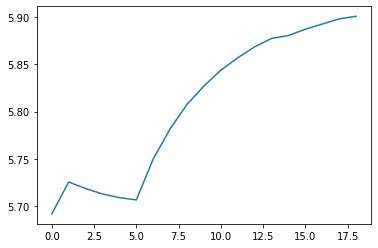

In [84]:
plot(losses)

In [85]:
res = odeint(gnn_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-4, atol=1e-4)

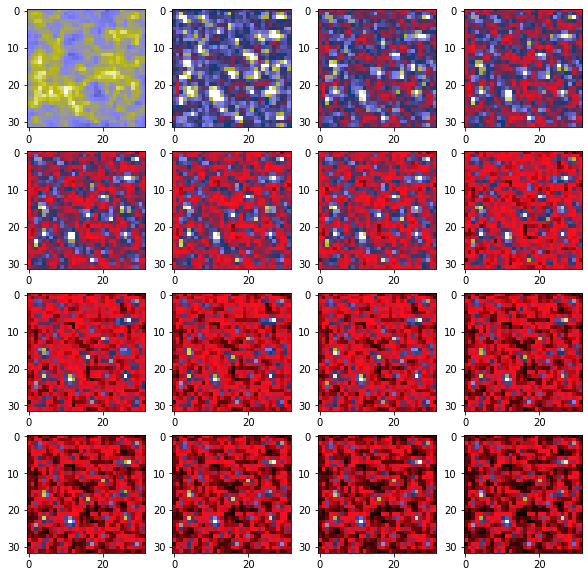

In [86]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [87]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

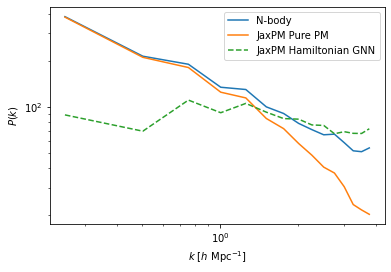

In [88]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM Pure PM')
loglog(k, pk_c, '--', label='JaxPM Hamiltonian GNN')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

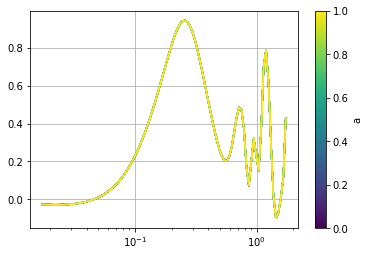

In [89]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,100)*sqrt(3)

for i, a in enumerate(scales[::2]): 
    semilogx(kvals, model.apply(params, kvals , jnp.atleast_1d(1)), color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

#xlim(kvals[0], 1)
#ylim(0,5)
grid()